In [43]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from tools import *
from fit_funcs import *
from entropy import *
import costfun.costfun as cost
import utils.figures as fig_help
from RandomMatrixTheory import goe
import utils.tools as tools

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:200])
colors_ls_cyc = itertools.cycle(colors_ls)

markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

linestyle_ls = ['-','--',':', '-.']
linestyle = itertools.cycle(linestyle_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
from scipy.interpolate import UnivariateSpline as InterpolateSpline
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists

base_dir = "../results2/PBC/"

print(base_dir[2:])

/Users/rafal.swietek/Projects/CODES/QHamSolver/pertIsing/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
/results2/PBC/


$$\Large H=\sum_{j=1}^L h_j\sigma^z_j+\frac{1}{\sqrt{L}}\sum_{i\neq j=1}^LJ_{ij}\sigma^z_i\sigma^z_j+\frac{g}{L\ln{L}}\sum_{j=1}^L\sigma^x_j$$
$$\Large h_j,J_{i,j}\sim\mathcal{N}(0,1)$$

In [36]:
L=15
g=1.0


plot_gaps = 1

b = 1.5

# g_vals = np.linspace(0.5, 15.5, 31)
g_vals = np.array([*np.linspace(0.1, 4, 40), *np.linspace(4.2, 10, 30)])
g_vals = np.linspace(0.1, 4, 40)
print(g_vals)

sub_sizes = np.arange(0, L+1)

sizes = np.arange(8, 17, 1)

interpolate = 1

nu = 0.25

for nu in [500, 0.1, 0.25, 0.5, 1.0]:
# for nu in [1.0]:
    frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

    folder_base = f'./collected data/'
    folder = folder_base + base_dir[3:] + f"nu={nu}/"
    os.makedirs(folder_base, exist_ok=True)
    os.makedirs(folder, exist_ok=True)

    perturbation = []
    gaps = []
    Ssite_av = []
    for L in sizes:
        # g_vals = np.linspace(0.1, 4, 40) if L > 12 else np.array([*np.linspace(0.05, 2, 40), *np.linspace(2.2, 10, 40)])
        sub_sizes = np.arange(0, L+1)
        name_out = folder + f'_L={L}.hdf5'

        entropy         = np.zeros((sub_sizes.size, g_vals.size)); entropy.fill(np.nan)
        entropy_site    = np.zeros((sub_sizes.size, g_vals.size)); entropy_site.fill(np.nan)
        gap_ratio       = np.zeros((g_vals.size));                 gap_ratio.fill(np.nan)
        realisations    = np.zeros((g_vals.size));                 realisations.fill(np.nan)
        for ii, g in enumerate(g_vals):
            name = base_dir + 'Entropy/Eigenstate/' + info(L=L, g=g, ext='.hdf5')
            
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('mean energies'))
                    ratio = np.array(file.get('gap ratio'))
                    realis = np.array(file.get('realisations'))[0]
                    realisations[ii] = realis
                    
                    dim = energies.size
                    num = frac(dim)
                    # print(dim, num)
                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if my_max >= dim: my_max = dim

                    try:
                        if num == 500:          gap_ratio[ii] = np.array(file.get('gap ratio 500'))
                        elif num == dim//2:     gap_ratio[ii] = np.array(file.get('gap ratio D/2'))
                        else:
                            # print("otherwise")
                            gap_ratio[ii] = np.mean(ratio[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(ratio)
                        for LA in sub_sizes:
                            S = np.array(file.get('entropies'))[LA]
                            Ssite = np.array(file.get('single_site_entropy'))[LA]
                            entropy[LA][ii]         = np.mean(S[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(S)
                            entropy_site[LA][ii]    = np.mean(Ssite[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(Ssite)
                    except TypeError:
                        print(ratio)
            else:
                print(name)
        if not np.all( np.isnan(realisations) ):
            print("SAVED:", name_out)
            hf = h5py.File(name_out, 'w')
            hf.create_dataset('perturbation',           g_vals.shape,           data = g_vals)
            hf.create_dataset('gap_ratio',              gap_ratio.shape,        data = gap_ratio)
            hf.create_dataset('entropy',                entropy.shape,          data = entropy)
            hf.create_dataset('single_site_entropy',    entropy_site.shape,     data = entropy_site)
            hf.create_dataset('realisations',           realisations.shape,     data = realisations)
            hf.close()
    

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6
 3.7 3.8 3.9 4. ]
../results/PBC/Entropy/Eigenstate/_L=8,g=2.1.hdf5
../results/PBC/Entropy/Eigenstate/_L=8,g=2.3.hdf5
../results/PBC/Entropy/Eigenstate/_L=8,g=2.5.hdf5
../results/PBC/Entropy/Eigenstate/_L=8,g=2.7.hdf5
../results/PBC/Entropy/Eigenstate/_L=8,g=2.9.hdf5
../results/PBC/Entropy/Eigenstate/_L=8,g=3.1.hdf5
../results/PBC/Entropy/Eigenstate/_L=8,g=3.3.hdf5
../results/PBC/Entropy/Eigenstate/_L=8,g=3.5.hdf5
../results/PBC/Entropy/Eigenstate/_L=8,g=3.7.hdf5
../results/PBC/Entropy/Eigenstate/_L=8,g=3.9.hdf5
SAVED: ./collected data/results/PBC/nu=500/_L=8.hdf5
../results/PBC/Entropy/Eigenstate/_L=9,g=2.1.hdf5
../results/PBC/Entropy/Eigenstate/_L=9,g=2.3.hdf5
../results/PBC/Entropy/Eigenstate/_L=9,g=2.5.hdf5
../results/PBC/Entropy/Eigenstate/_L=9,g=2.7.hdf5
../results/PBC/Entropy/Eigenstate/_L=9,g=2.9.hdf5
../results/PBC/Entropy/Eigenstate

[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5]


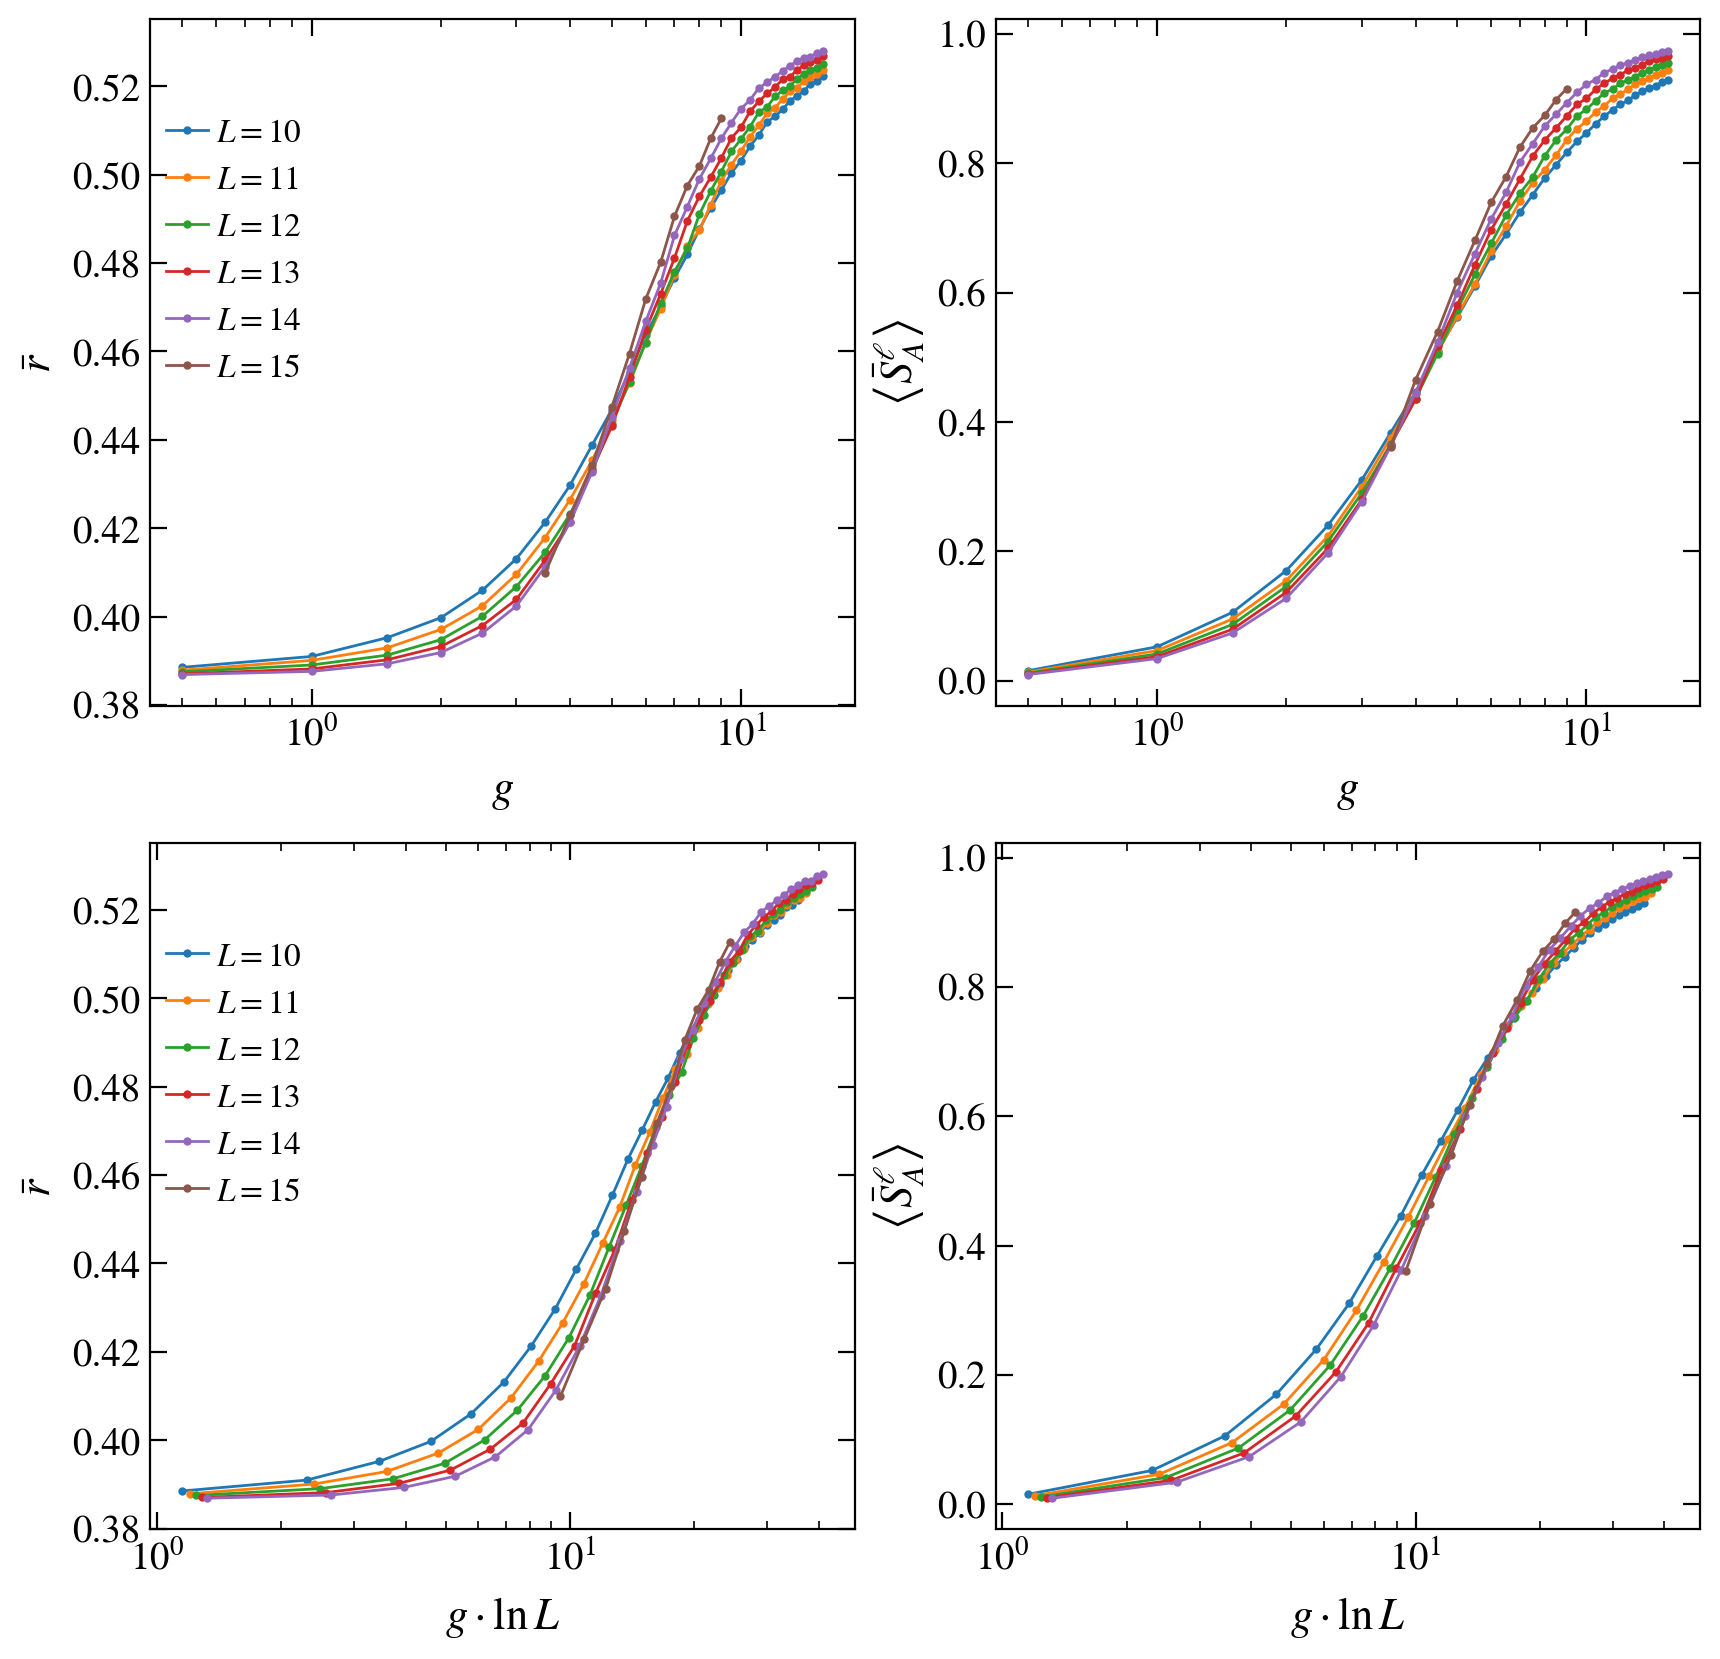

In [44]:
L=15
g=1.0


plot_gaps = 1

b = 1.5

g_vals = np.linspace(0.5, 15.5, 31)
print(g_vals)

sub_sizes = np.arange(0, L+1)

sizes = np.arange(10, 16, 1)

interpolate = 0

nu = 0.5
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

rescale_func        = [lambda x, L: x, lambda x, L: x * np.log(L)]#, lambda x, L: x * np.sqrt(L)]
rescale_func_names  = [r"$g$"        , r"$g\cdot\ln{L}$"         ]#, r"$g\cdot\sqrt{L}$"]


fig, axes = plt.subplots( nrows=len(rescale_func), ncols=2, figsize=(10,5 * len(rescale_func)), dpi = 200, sharex='row')

perturbation = []
gaps = []
Ssite_av = []
for L in sizes:
    LA = 2

    sub_sizes = np.arange(0, L+1)
    name_out = folder + f'_L={L}.hdf5'

    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            g_vals       = np.array(file.get('perturbation'))
            gap_ratio    = np.array(file.get('gap_ratio'))
            entropy      = np.array(file.get('entropy'))
            entropy_site = np.array(file.get('single_site_entropy'))
    else:
        print(name_out)
    
    ent = np.zeros(g_vals.shape)
    for ii in range(g_vals.size):
        # ent[ii] = np.transpose(entropy)[ii][LA] / page(LA, L - LA)
        ent[ii] = np.mean(np.transpose(entropy_site[:-1])[ii]) / page(1, L-1)
    
    perturbation.append( g_vals )
    gaps.append(gap_ratio)
    Ssite_av.append(ent)

for iabc in range(len(rescale_func)):
    axis = [axes[iabc][0], axes[iabc][1]] if len(rescale_func) > 1 else axes
    for ii, L in enumerate(sizes):
        g_vals_resc = rescale_func[iabc](perturbation[ii], L)
        if interpolate:
            r_spl = InterpolateSpline(g_vals_resc, gaps[ii],   k=5)
            S_spl = InterpolateSpline(g_vals_resc, Ssite_av[ii], k=5)
            
            # bucket = 100
            # xx        = np.sort( np.array([*np.linspace(perturbation[ii][0], perturbation[ii][-1], 1000), *perturbation[ii]]) )
            # gap_ratio = tools.remove_fluctuations(r_spl(xx), bucket_size=bucket)[bucket//2 : -bucket//2]
            # entropy   = tools.remove_fluctuations(S_spl(xx), bucket_size=bucket)[bucket//2 : -bucket//2]
            
            gap_ratio = r_spl(g_vals_resc)
            entropy   = S_spl(g_vals_resc)
        else:
            gap_ratio = gaps[ii]
            entropy = Ssite_av[ii]
        axis[0].plot(g_vals_resc, gap_ratio, marker='o', markersize=2, lw=1, label=r"$L=%d$"%L)
        axis[1].plot(g_vals_resc, entropy,   marker='o', markersize=2, lw=1)

    # axis[0].set_ylim(0.38,0.46)
    # axis[1].set_ylim(0.0,0.46)
    # if iabc == 0:   
    #     axis[0].set_xlim(2.0, 8.0)
    # elif iabc == 1:   
    #     axis[0].set_xlim(10.0, 25.0)
    # elif iabc == 2:   
    # axis[0].set_xlim(0.05, 4.0)
    # axis[1].set_xlim(0.05, 4.0)


    # axis[1].set_xlim(4 * min(np.array(perturbation).flatten()), 0.8*max(np.array(perturbation).flatten()))
    # axis[0].axhline(y=0.3863, ls='--', color='black')
    # axis[0].axhline(y=0.5307, ls='--', color='black')

    # axis[1].set_ylim(0.3 + 0.1*iabc,0.9)

    fig_help.set_plot_elements(axis[0], ylabel=r"$\bar{r}$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False, xscale='log')
    fig_help.set_legend(axis[0], loc = 'upper left', fontsize=12, anchor=(-0.02, 0.9))

    fig_help.set_plot_elements(axis[1], ylabel=r"$\left\langle\bar{S}_A^{\ell}\right\rangle$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False, xscale='log')

    # for ax in axis:
    #     ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    #     ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    #     ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    #     ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))


fig.subplots_adjust(wspace = 0.2, hspace=0.2)

In [48]:
j = np.linspace(0, 1, 100)


aa = (1+j) / 2. * np.log( (1+j) / 2. ) + (1-j) / 2. * np.log( (1-j) / 2. )

print(-aa / np.log(2))

[1.         0.9999264  0.99970558 0.9993375  0.99882209 0.99815923
 0.9973488  0.99639062 0.9952845  0.99403021 0.9926275  0.99107606
 0.98937558 0.98752571 0.98552605 0.98337619 0.98107567 0.97862399
 0.97602065 0.97326507 0.97035666 0.96729478 0.96407876 0.9607079
 0.95718144 0.95349858 0.9496585  0.9456603  0.94150308 0.93718586
 0.93270761 0.92806728 0.92326375 0.91829583 0.91316232 0.90786192
 0.90239328 0.89675502 0.89094565 0.88496364 0.87880738 0.87247521
 0.86596535 0.85927598 0.85240518 0.84535094 0.83811115 0.83068364
 0.82306608 0.81525608 0.80725111 0.79904852 0.79064555 0.78203929
 0.77322667 0.76420451 0.75496941 0.74551784 0.73584607 0.72595015
 0.71582593 0.70546904 0.69487484 0.68403844 0.67295463 0.66161791
 0.65002242 0.63816195 0.62602984 0.61361902 0.6009219  0.58793037
 0.5746357  0.56102849 0.5470986  0.53283506 0.51822597 0.50325833
 0.48791799 0.47218938 0.45605537 0.43949699 0.42249312 0.40502013
 0.38705142 0.36855678 0.34950164 0.32984607 0.30954343 0.28853

## BETA FUNCTION

No handles with labels found to put in legend.
No handles with labels found to put in legend.


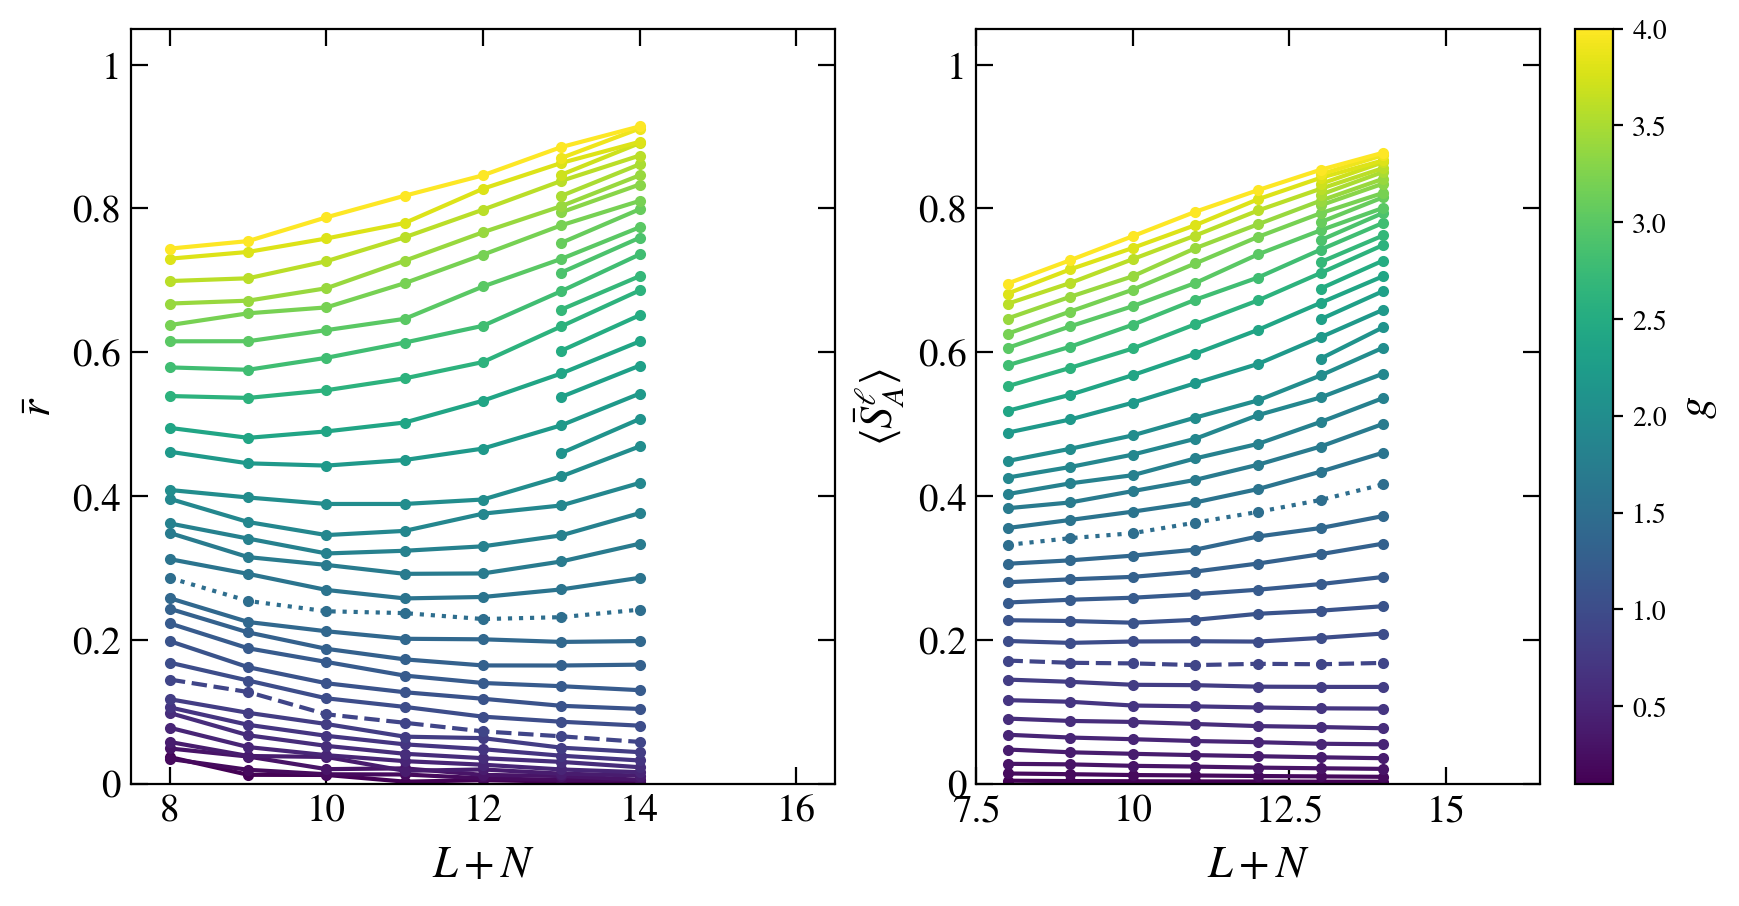

In [219]:
L=15

J=1


alfa=1
h=1.0
w=0.5
zeta=0.2

N=3
gamma=1.0
ini_ave=0
L = L - N
scaled_disorder = 0

alfa_crit = 0.75
if J == 0.5:    alfa_crit = 0.77
elif J == 1:    alfa_crit = 0.73
elif J == 2:    alfa_crit = 0.72
elif J == 3:    alfa_crit = 0.72
else:           alfa_crit = 1/np.sqrt(2)
sub_sizes = np.arange(0, L+1)

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)
# fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

# axis = [*axes, ax]

sizes = np.arange(8, 15, 1)

interpolate = 0

p = 1       # number of last spins
nu = 0.1
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data_scaled disorder/' if scaled_disorder else f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)
    
xlab = r"$L+N$"

def pade_fun(x, c1, d1):
    return (x + c1) / (x + d1)

def other_fit(x, c1, c2):
    return c1 / x + c2

for idx1 in range(2):
    
    interaction = []
    ydata = []
    for L in sizes:
        LA = 2

        name_out = folder + f'_L={L}.hdf5'

        if exists(name_out):
            with h5py.File(name_out, "r") as file:
                g_vals       = np.array(file.get('perturbation'))
                gap_ratio    = np.array(file.get('gap_ratio'))
                entropy      = np.array(file.get('entropy'))
                entropy_site = np.array(file.get('single_site_entropy'))
        else:
            print(name_out)

        # if interpolate:
        #     gap_ratio_spl = InterpolateSpline(alfa_vals, gap_ratio,                               k=5, s=0)
        #     entropy_spl =   InterpolateSpline(alfa_vals, entropy[LA] / page(LA, L-LA), k=5, s=0)
            
        #     bucket = 10
        #     alfa_vals = np.sort( np.array([*np.linspace(alfa_vals[0], alfa_vals[-1], 100), *alfa_vals]) )
        #     gap_ratio = tools.remove_fluctuations(gap_ratio_spl(alfa_vals), bucket_size=bucket)[bucket//2 : -bucket//2]
        #     entropy   = tools.remove_fluctuations(entropy_spl(alfa_vals),   bucket_size=bucket)[bucket//2 : -bucket//2]
        #     alfa_vals = alfa_vals[bucket//2 : -bucket//2]
        # else:
        
        ent = np.zeros((g_vals.size))
        for ii in range(g_vals.size):
            # ent[ii] = np.transpose(entropy)[ii][LA] / page(LA, L - LA)
            ent[ii] = np.mean(np.transpose(entropy_site)[ii]) / page(1, L-1)
        # entropy = np.mean(entropy_site) / page(1, L-1)
        interaction.append(g_vals)
        ydata.append((gap_ratio - 0.3863) / (0.5307 - 0.3863) if idx1 == 0 else ent)

    # norm is a class which, when called, can normalize data into the
    # [0.0, 1.0] interval.
    norm = matplotlib.colors.Normalize(
        vmin=np.min(g_vals),
        vmax=np.max(g_vals))


    # create a ScalarMappable and initialize a data structure
    s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
    s_m.set_array([])

    ydata = np.transpose( np.array(ydata) )

    idx_c = 0
    g_crit = 0.9
    g_crit2 = 1.5

    envelope_ydata = []
    envelope_xdata = []
    for ii_a, g in enumerate(g_vals):
        if g == g_crit: idx_c = ii_a

        D1 = np.diff(ydata[ii_a]) / np.log(2)
        # D1 = ( D1[:-1] + D1[1:] ) / 2.0
        xx = sizes if idx1 < 2 else sizes[:-1]
        yy = ydata[ii_a] if idx1 < 2 else D1
        axis[idx1].plot(xx, yy, marker='o', markersize=3, lw=1.5, color=s_m.to_rgba(g), ls = '--' if np.abs(g - g_crit) < 1e-8 else (':' if np.abs(g - g_crit2) < 1e-8 else '-'))
        # if interpolate:
        #     spl = make_spline(sizes, ydata[ii_a])
        #     xx = np.linspace(sizes[0], sizes[-1], 50)
        #     yy = spl(xx)
        #     D1 = np.gradient(yy, xx[1] - xx[0]) / np.log(2)
        #     # D1 = ( D1[:-1] + D1[1:] ) / 2.0
        #     yy = yy if idx1 < 2 else D1
        
        my_fit = pade_fun if alfa > 0.77 else other_fit
        # try:
        #     pars, pconv = fit(my_fit,
        #                     xdata = xx[:-2],
        #                     ydata = yy[:-2])
        #     # print(alfa, np.diag(pconv)**2)
        #     aaaa = np.linspace(xx[0], xx[-1], 10000)
        #     axis[idx1].plot(aaaa, my_fit(aaaa, *pars), lw=1.5, color=s_m.to_rgba(g), ls = '--' if g == g_crit else (':' if g == g_crit2 else '-'))
        # except RuntimeError:
        #     print(alfa)
        
# axis[0].axhline(y=0.3863, ls='--', color='black')
# axis[0].axhline(y=0.5307, ls='--', color='black')
    
    axis[idx1].set_xlim(7.5, 16.5)
    axis[idx1].set_ylim(0, 1.05)
cbar = fig.colorbar(s_m)
cbar.set_label(r"$g$", fontsize=16)
# ax.set_xlim(8, 14)


fig_help.set_plot_elements(axis[0], ylabel=r"$\bar{r}$", xlabel=xlab, font_size=14, set_legend=False)
fig_help.set_legend(axis[0], loc = 'center left', fontsize=12, anchor=(-0.02, 0.35))
fig_help.set_plot_elements(axis[1], ylabel=r"$\langle \bar{S}_A^{\ell} \rangle$", xlabel=xlab, font_size=14, set_legend=False)
fig_help.set_legend(axis[1], loc = 'center left', fontsize=12, anchor=(-0.02, 0.35))
# fig_help.set_plot_elements(ax, ylabel=r"$\bar{D}(L)$", xlabel=xlab, font_size=14, set_legend=False)

for aa in [axis]:
    for ax in np.array(aa).flatten():
        ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

# axis[0].annotate(r"(a) $r$", fontsize=16, xy=(0.03, 0.08), xycoords='axes fraction')
# axis[1].annotate(r"(b) $\bar{S}^{p=1}$", fontsize=16, xy=(0.03, 0.08), xycoords='axes fraction')
# axis[0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
# axis[1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)

fig.subplots_adjust(wspace = 0.2, hspace=0.2)
plt.savefig("Fig_scaling.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("Fig_scaling.png", bbox_inches = 'tight', pad_inches=0.02)

[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


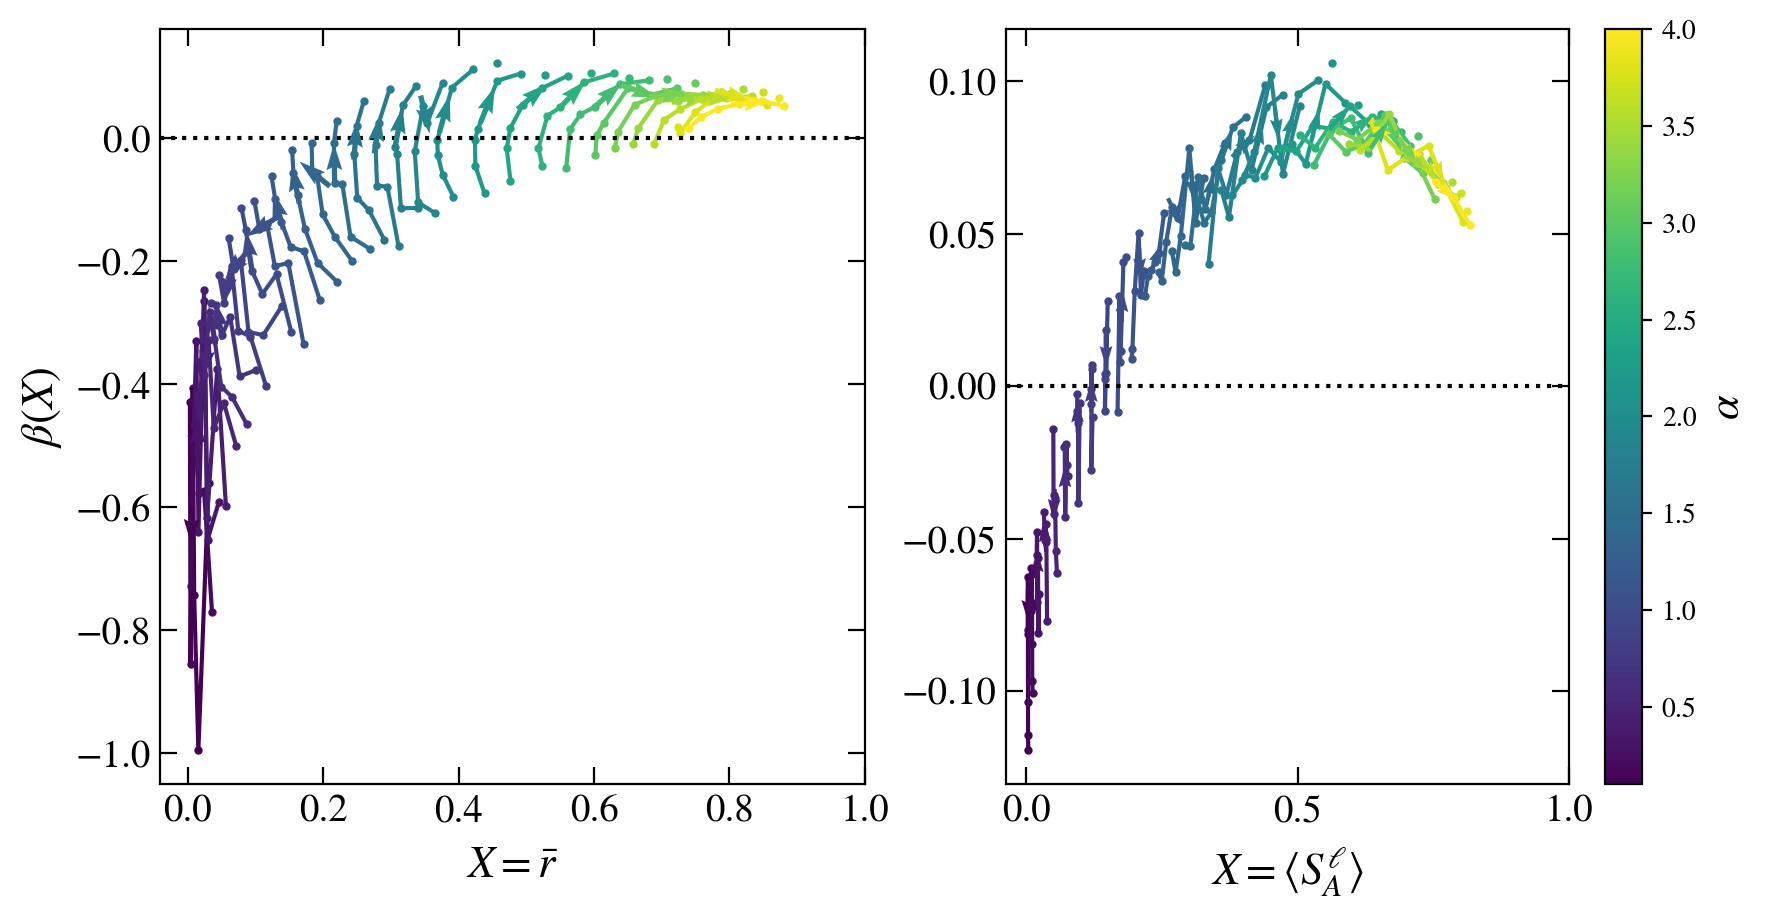

In [204]:
L=15

g_vals = np.linspace(0.5, 15.5, 31)
print(g_vals)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)

sizes = np.arange(8, 15, 1)

interpolate = 0
use_fit = 0
bin_size = 10

nu = 1.0
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

gc = 4.5
ylab = r"$\beta(X)$"

def pade_fun(x, c1, d1):
    return (x + c1) / (x + d1)

def other_fit(x, c1, c2, c3):
    return c1 / x**2 + c2 / x**3 + c3

# def other_fit(x, c1, c2, c3, c4, c5):
#     return c1 * (x)**4 + c2 * (x)**3 + c3 * (x)**2 + c4 * (x) + c5
for idx1 in range(2):
    
    interaction = []
    ydata = []
    for L in sizes:
        LA = L - 1

        name_out = folder + f'_L={L}.hdf5'

        if exists(name_out):
            with h5py.File(name_out, "r") as file:
                g_vals       = np.array(file.get('perturbation'))
                gap_ratio    = np.array(file.get('gap_ratio'))
                entropy      = np.array(file.get('entropy'))
                entropy_site = np.array(file.get('single_site_entropy'))
        else:
            print(name_out)

        # if interpolate:
        #     gap_ratio_spl = InterpolateSpline(alfa_vals, gap_ratio,                               k=5, s=0)
        #     entropy_spl =   InterpolateSpline(alfa_vals, entropy[LA] / page(LA, L-LA), k=5, s=0)
            
        #     bucket = 10
        #     alfa_vals = np.sort( np.array([*np.linspace(alfa_vals[0], alfa_vals[-1], 100), *alfa_vals]) )
        #     gap_ratio = tools.remove_fluctuations(gap_ratio_spl(alfa_vals), bucket_size=bucket)[bucket//2 : -bucket//2]
        #     entropy   = tools.remove_fluctuations(entropy_spl(alfa_vals),   bucket_size=bucket)[bucket//2 : -bucket//2]
        #     alfa_vals = alfa_vals[bucket//2 : -bucket//2]
        # else:
        
        ent = np.zeros((g_vals.size))
        for ii in range(g_vals.size):
            ent[ii] = np.mean(np.transpose(entropy_site)[ii]) / page(1, L-1)
        # entropy = np.mean(entropy_site) / page(1, L-1)
        interaction.append(g_vals)
        ydata.append((gap_ratio - 0.3863) / (0.5307 - 0.3863) if idx1 == 0 else ent)

    # norm is a class which, when called, can normalize data into the
    # [0.0, 1.0] interval.
    norm = matplotlib.colors.Normalize(
        vmin=np.min(g_vals),
        vmax=np.max(g_vals))


    # create a ScalarMappable and initialize a data structure
    s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
    s_m.set_array([])

    ydata = np.transpose( np.array(ydata) )

    idx_c = 0

    envelope_ydata = []
    envelope_xdata = []
    for ii_a, g in enumerate(g_vals):
        if g == 4.5: idx_c = ii_a

        if not use_fit:
            xx = np.zeros( (sizes.size - 1) )
            beta = np.zeros( (sizes.size - 1) )
            for ii in range(sizes.size - 1):
                xx[ii] = ydata[ii_a][ii+1]
                beta[ii] = ( np.log(ydata[ii_a][ii+1]) - np.log(ydata[ii_a][ii])) / ( sizes[ii+1] - sizes[ii]) / np.log(2)
                envelope_ydata.append(beta[ii])
                envelope_xdata.append(xx[ii])
            
            axis[idx1].plot(xx, beta, marker='o', markersize=2, lw=1.5, color='red' if g==gc else s_m.to_rgba(g))
            i1 = xx.size // 2
            u = xx[i1+1] - xx[i1]
            v = beta[i1+1] - beta[i1]
            pos_x = xx[i1] + u/2
            pos_y = beta[i1] + v/2
            norm = np.sqrt(u**2+v**2)

            axis[idx1].quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", color='red' if g==gc else s_m.to_rgba(g), lw=0)
        else:
            my_fit = pade_fun if g > gc else other_fit
            pars, pconv = fit(my_fit,
                                xdata = sizes,
                                ydata = ydata[ii_a])
            aaaa = np.linspace(sizes[0], sizes[-1], 100)
            deriv = np.gradient( my_fit(aaaa, *pars), aaaa[1] - aaaa[0] )
            axis[idx1].plot(my_fit(aaaa, *pars), deriv, lw=1.5, color='red' if g==gc else s_m.to_rgba(g))
            
            envelope_ydata = [*envelope_ydata, *deriv]
            envelope_xdata = [*envelope_xdata, *my_fit(aaaa, *pars)]

            aaaa = my_fit(aaaa, *pars)
            i1 = aaaa.size // 2
            u = aaaa[i1+1] - aaaa[i1]
            v = deriv[i1+1] - deriv[i1]
            pos_x = aaaa[i1] + u/2
            pos_y = deriv[i1] + v/2
            norm = np.sqrt(u**2+v**2)
        
            axis[idx1].quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", 
                               linewidth=0, width=0.02, headwidth=3, color='red' if g==gc else s_m.to_rgba(g), lw=0)
    
    permut = np.argsort( np.array(envelope_xdata) )
    envelope_ydata = np.array(envelope_ydata)[permut]
    envelope_xdata = np.array(envelope_xdata)[permut]

    size = len(envelope_xdata)
    envelope = np.zeros( (size // bin_size) )
    xxx = np.zeros( (size // bin_size) )
    for k in range(envelope.size):
        idx_r = (k+1) * bin_size if k < envelope.size-1 else -1
        idx = np.argmax(envelope_ydata[k * bin_size : idx_r])
        envelope[k] = envelope_ydata[k * bin_size : idx_r][idx]
        xxx[k]      = envelope_xdata[k * bin_size : idx_r][idx]

    # axis[idx1].plot(xxx, envelope, lw=2, color='k', ls='--')

    # def fitta(x, c1, c2, c3, c4):
    #     return c1 * (x-1)**4 + c2 * (x-1)**3 + c3 * (x-1)**2 + c4 * (x-1)

    # pars, pconv = fit(fitta,
    #                     xdata = xxx,
    #                     ydata = envelope)
    
    # # axis[idx1].plot(new_xx, beta_0, lw=2, color='k', ls='--')
    # aaaa = np.linspace(min(ydata.flatten()), 1, 10000)
    # axis[idx1].plot(aaaa, fitta(aaaa, *pars), lw=2, color='k', ls='--')
    
    # xxx = aaaa
    # envelope = fitta(aaaa, *pars)
    # Sc_idx = np.argwhere(np.abs(fitta(aaaa, *pars)) < 1e-4)[0][0]

    # def fitta(x, a, Sc):
    #     return a * (x - Sc)
    # # print(Sc_idx, envelope[Sc_idx - 20 : Sc_idx + 20])
    # pars, pconv = fit(fitta,
    #                     xdata = xxx[Sc_idx - 100 : Sc_idx + 100],
    #                     ydata = envelope[Sc_idx - 100 : Sc_idx + 100])
    # print(1./ (pars[0] * pars[1]))
    # axis[idx1].plot(xxx[Sc_idx - 2000 : Sc_idx + 2000], fitta(xxx[Sc_idx - 2000 : Sc_idx + 2000], *pars), lw=1, color='gray', ls='-')
    
    
    axis[idx1].set_xlim(None, 1)
    axis[idx1].axhline(y=0, ls=':', c='k')
cbar = fig.colorbar(s_m)
cbar.set_label(r"$\alpha$", fontsize=16)



fig_help.set_plot_elements(axis[0], xlabel=r"$X=\bar{r}$", ylabel=ylab, font_size=14, set_legend=False)
fig_help.set_legend(axis[0], loc = 'center left', fontsize=12, anchor=(-0.02, 0.35))
fig_help.set_plot_elements(axis[1], xlabel=r"$X=\langle {S}_A^{\ell}\rangle$", ylabel="", font_size=14, set_legend=False, xscale='linear')
fig_help.set_legend(axis[1], loc = 'center left', fontsize=12, anchor=(-0.02, 0.35))

fig.subplots_adjust(wspace = 0.2, hspace=0.2)

## SPECTRAL FORM FACTOR

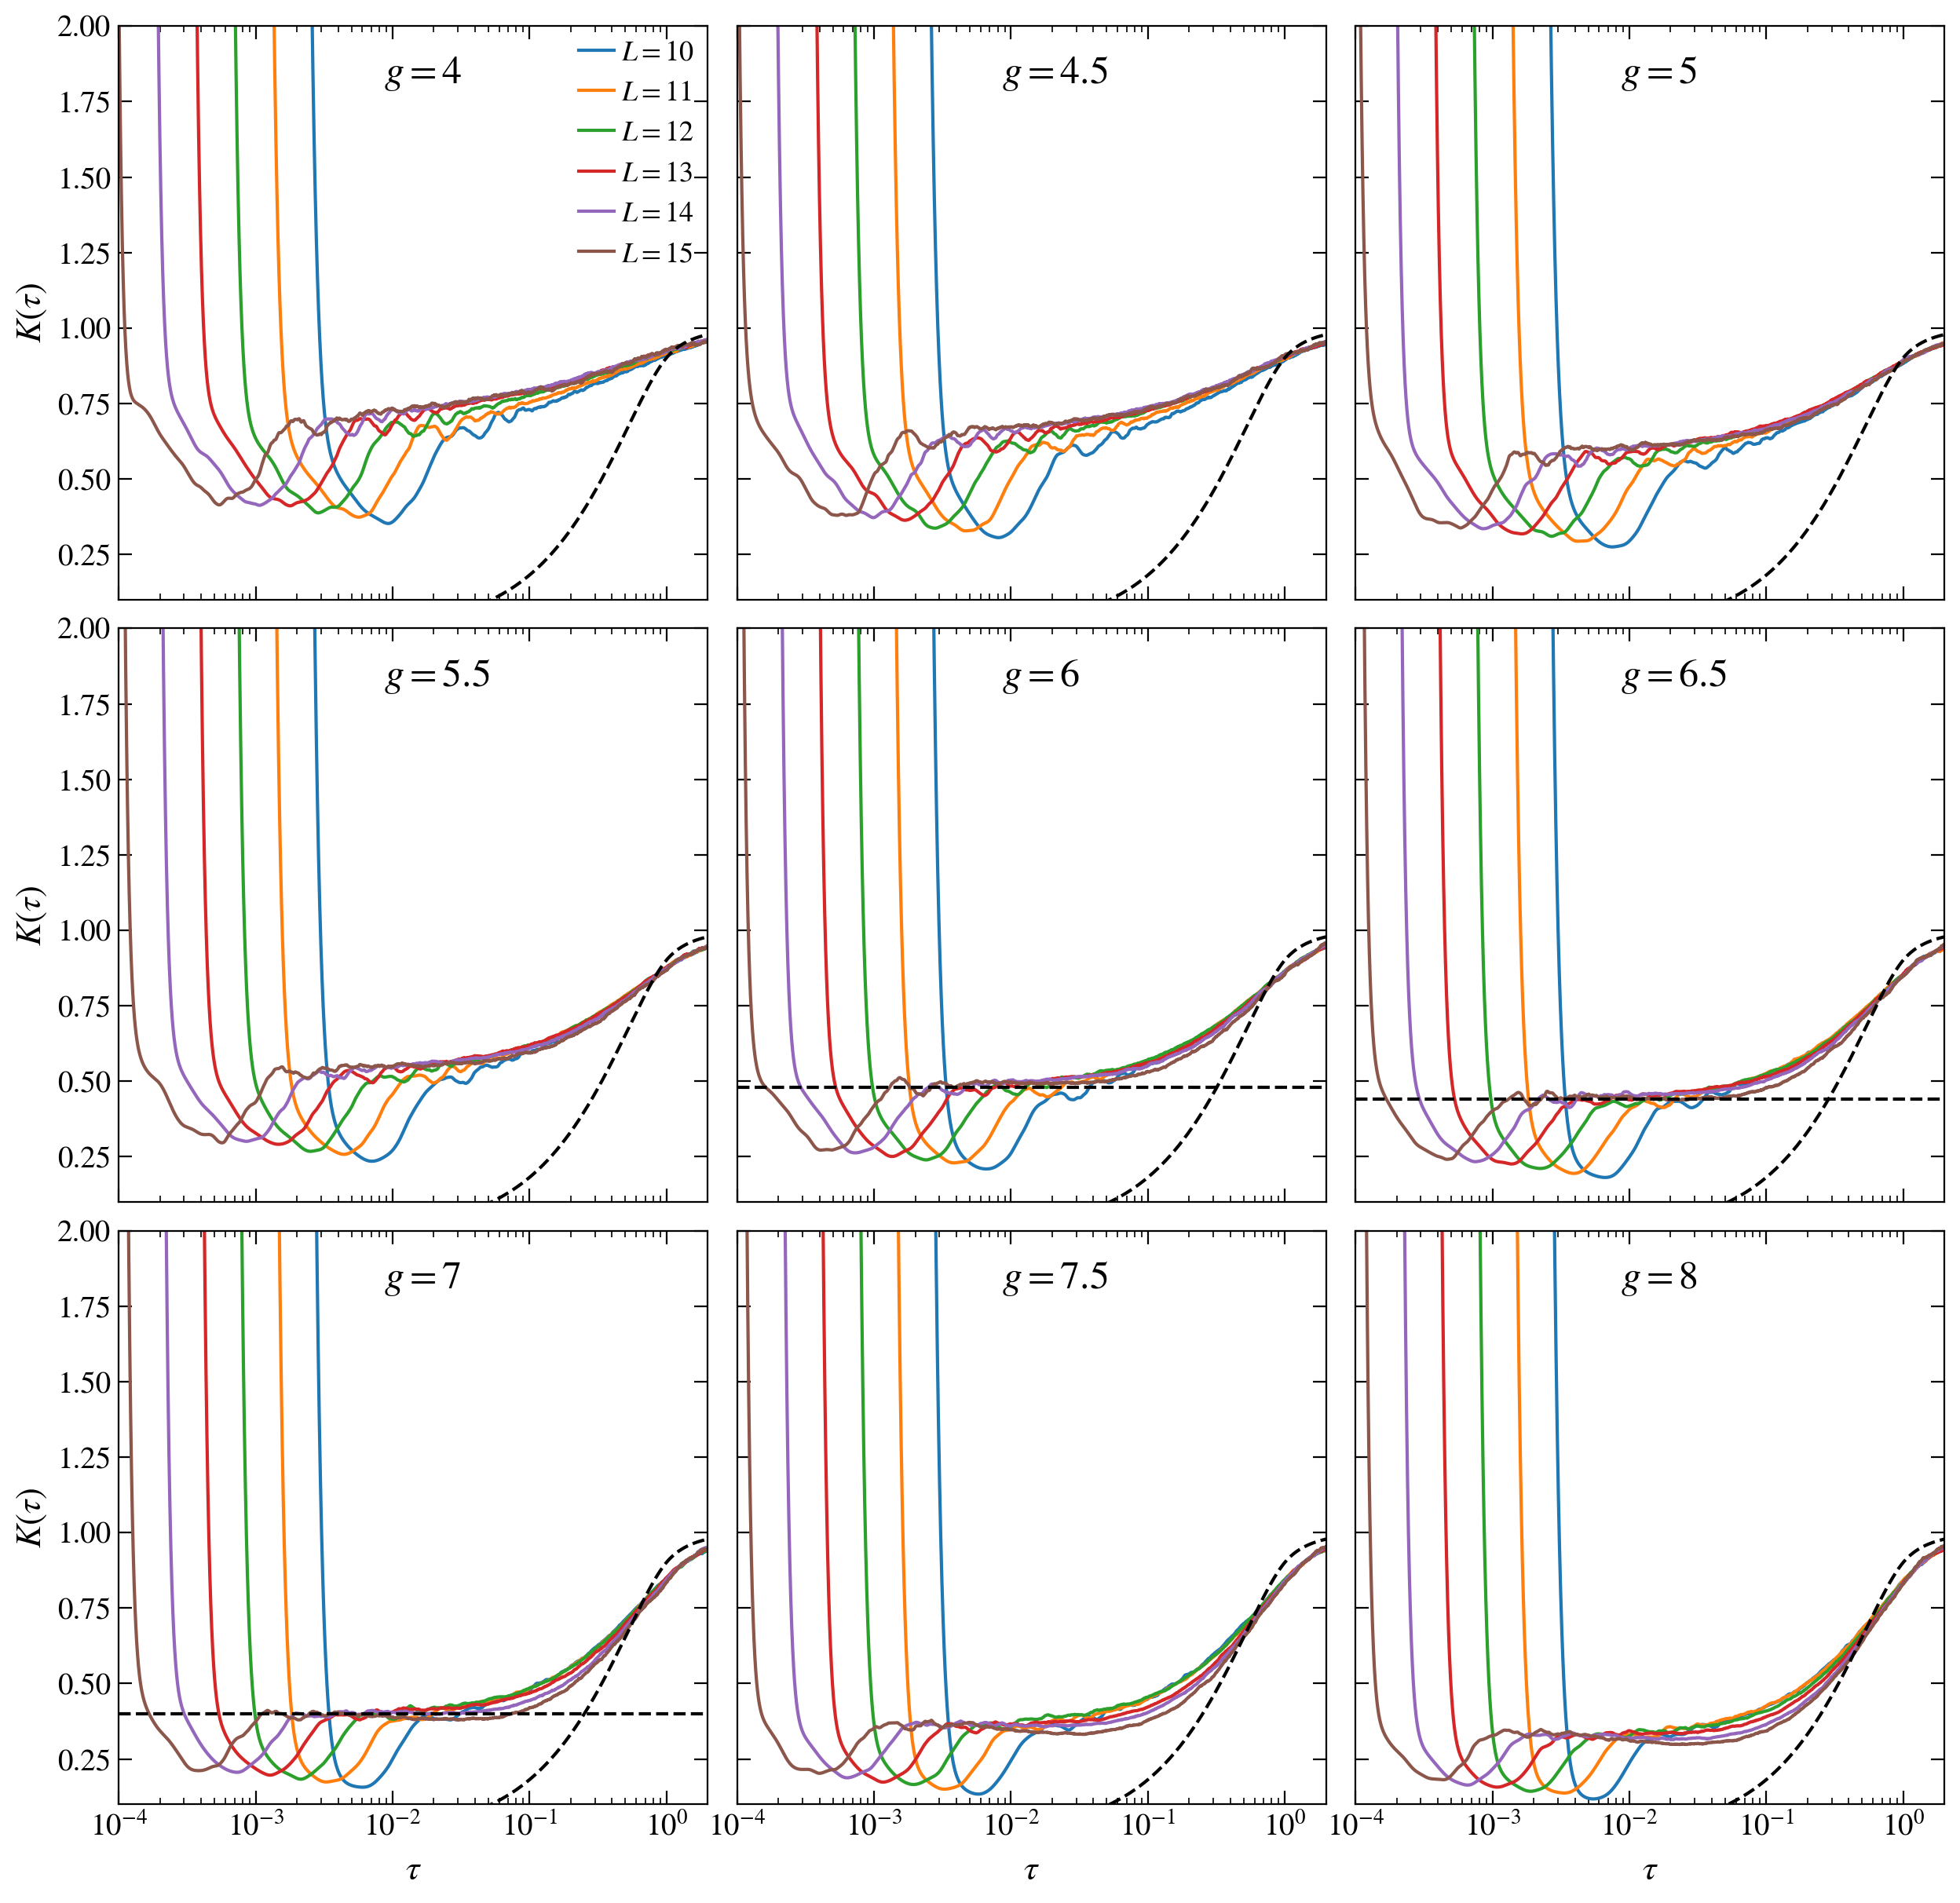

In [15]:
L=15
g=1.0

sizes = np.arange(10, 16, 1)

bucket = 50
folded = 1
running_mean = 1
eta = 0.5

g_vals = [5., 5.5, 6.]

fig, axis = plt.subplots( nrows=3, ncols=3, figsize=(15,15), dpi = 200, sharex=True, sharey=True)

for row in range(3):
        if row == 0:    g_vals = [4, 4.5, 5]
        elif row == 1:    g_vals = [5.5, 6, 6.5]
        elif row == 2:    g_vals = [7, 7.5, 8.0]
        # if row == 0:    g_vals = [0.5, 0.8, 1.]
        # elif row == 1:    g_vals = [1.2, 1.5, 1.8]
        # elif row == 2:    g_vals = [2, 3, 4.0]

        for ii_g, g in enumerate(g_vals):
            for L in sizes:
                name = base_dir + 'SpectralFormFactor/' + info(L=L, g=g, ext='.hdf5')
                if exists(name):
                    with h5py.File(name, "r") as file:
                        tHtyp = np.array(file.get('tH_typ')) / 2 / np.pi
                        times = np.array(file.get('times_fold')) / tHtyp if folded else np.array(file.get('times'))
                        sff = np.array(file.get('sff_fold' if folded else 'sff_eta=%g'%eta))
                        try:
                            if sff.shape == (1, 5000):                             
                                times = times[0]
                                sff = sff[0]
                            if running_mean: sff = tools.remove_fluctuations(sff, bucket)
                            
                            sff = sff[bucket // 2 : -bucket // 2]
                            times = times[bucket // 2 : -bucket // 2]
                            axis[row][ii_g].plot(times, sff, label=r"$L=%d$"%L)
                        except IndexError:
                             print(name)
                else:
                    print(name)
            axis[row][ii_g].plot(times, goe.spectral_form_factor(times), ls='--', c='k')

            

            fig_help.set_plot_elements(axis[row][ii_g], ylabel=r"$K(\tau)$" if ii_g == 0 else "", xlabel=r"$\tau$" if row == 2 else "", font_size=14, set_legend=False, xscale='log', yscale='linear', ylim=(1e-1,2e0), xlim=(1e-4, 2))
            # axis[ii_g].set_title(r"$g=%g$"%g)
            axis[row][ii_g].annotate(r"$g=%g$"%g, fontsize=18, xy=(0.45, 0.9), xycoords='axes fraction')
axis[1][1].axhline(y=0.48, ls='--', c='k')
axis[1][2].axhline(y=0.44, ls='--', c='k')
axis[2][0].axhline(y=0.4, ls='--', c='k')
fig_help.set_legend(axis[0][0], loc = 'upper right', fontsize=13)

# fig_help.set_plot_elements(axis[1], ylabel=r"$\left\langle\bar{S}_A^{\ell}\right\rangle$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False)


fig.subplots_adjust(wspace = 0.05, hspace=0.05)
# plt.savefig("Fig_sff.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("Fig_sff.png", bbox_inches = 'tight', pad_inches=0.02)

## MATRIX ELEMENTS

[ 0.316228  0.354813  0.398107  0.446684  0.501187  0.562341  0.630957
  0.707946  0.794328  0.891251  1.        1.122018  1.258925  1.412538
  1.584893  1.778279  1.995262  2.238721  2.511886  2.818383  3.162278
  3.548134  3.981072  4.466836  5.011872  5.623413  6.309573  7.079458
  7.943282  8.912509 10.       11.220185 12.589254 14.125375 15.848932
 17.782794 19.952623 22.387211 25.118864 28.183829 31.622777 35.481339
 39.810717 44.668359 50.118723 56.234133 63.095734 70.794578 79.432823
 89.125094]
10 5000.0
11 4901.0
12 4000.0
13 3000.0
14 1704.0
10 5000.0
11 4901.0
12 4000.0
13 3000.0
14 1704.0


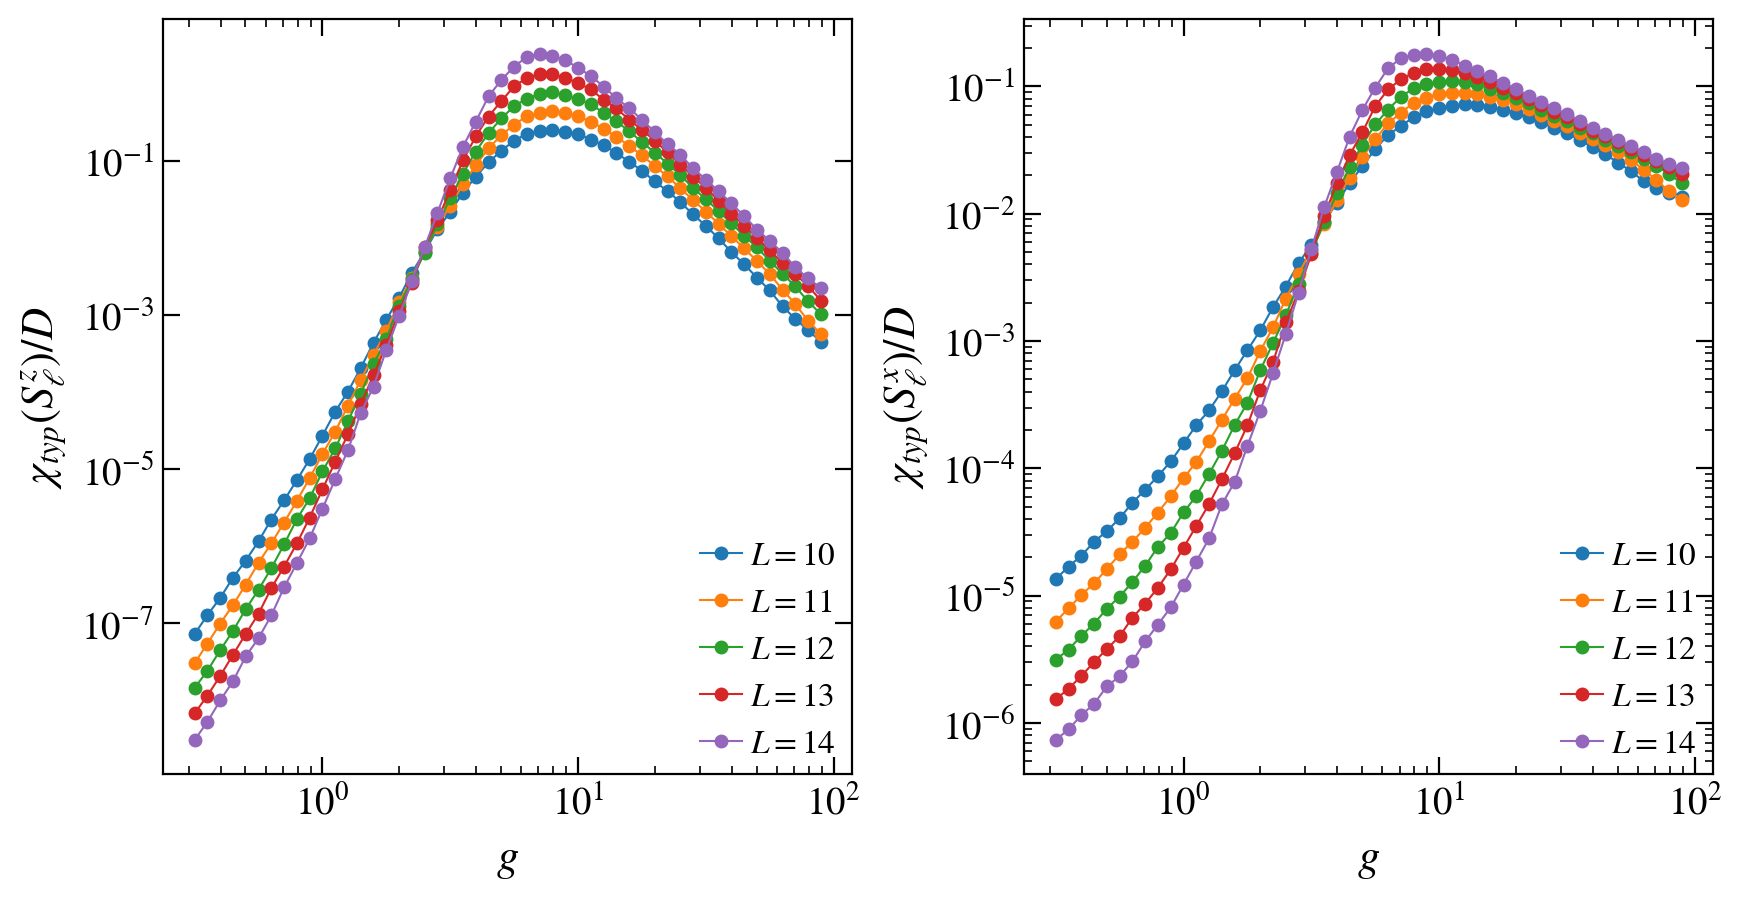

In [55]:
L=15

J=1
g=1
scaled_disorder = 1

# w_vals = np.unique( np.round( np.array( [ *np.linspace(0.4, 1.3, 19), *np.linspace(0.7, 0.82, 13)] ), 3) )
g_vals = np.linspace(0.2, 12.0, 60)
# g_vals = np.linspace(0.2, 12, 60)
g_vals = np.round(np.logspace(-0.5, 1.95, 50),6)
print(g_vals)

sizes = np.arange(10, 15, 1)

xlab = r"$g$"

fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharex=True)
ylab_in = ['S^z_\ell', 'S^x_\ell', 'S^z_\ell S^z_{\ell+1}', 'S^x_\ell S^x_{\ell+1}', 'K_\ell']
axes = axes.flatten()
for iii, operator_name in enumerate(['Sz', 'Sx']):
    p=0
    axis = axes[iii]
    if iii > 1: p=1
    for L in sizes:
        # g_vals = np.linspace(0.2, 12.0, 60) if L > 12 else np.linspace(0.1, 11.9, 60)
        dim = 2**L
        num_sites = L
        sites    = np.zeros((num_sites));    sites.fill(np.nan)
        agp      = np.zeros((g_vals.size, num_sites - p));    agp.fill(np.nan)
        typ_susc = np.zeros((g_vals.size, num_sites - p));    typ_susc.fill(np.nan)
        _var     = np.zeros((g_vals.size, num_sites - p));    _var.fill(np.nan)
        wH       = np.zeros((g_vals.size));                 wH.fill(np.nan)
        realisations = np.zeros((g_vals.size));             realisations.fill(np.nan)
        # susc = np.zeros((L));    sites.fill(np.nan)
        _exist = 0
        for ii, g in enumerate(g_vals):
            name = base_dir + 'MatrixElements/' + info(L=L, g=g, ext='.hdf5')
            if exists(name):
                with h5py.File(name, "r") as file:
                    sites        = np.array(file.get('sites')).astype(int)
                    agp[ii]      = np.array(file.get('AGP/' + operator_name))
                    # print('AGP/' + name)
                    typ_susc[ii] = np.array(file.get('TYP_SUSC/' + operator_name))
                    # mat_elem = np.transpose(np.array(file.get('DIAG_MAT/' + operator_name)))
                    # _var[ii]     = np.array([np.var(aa) for aa in mat_elem])
                    realisations[ii] = np.array(file.get('realisations'))
                    _exist = 1
            else:
                print(name)
            # name = base_dir + '

        if _exist:                
            print(L, min(realisations) )

            agp = np.transpose(agp)
            _var = np.transpose(_var)
            typ_susc = np.transpose(typ_susc)
            
            # _sites_ = [0, L//2, L - 2]
            # print(sites)
            # for ii, ell in enumerate(_sites_):
            idx = 0
            # axis.plot(g_vals, agp[idx] / dim, marker='o', label=r"$L+N=%d$"%L, markersize=4, lw=1)
            axis.plot(g_vals, typ_susc[idx] / dim, marker='o', label=r"$L=%d$"%L, markersize=4, lw=0.75)
            # print(_var(idx))
            # axis[ii].plot(w_vals, np.sqrt(_var[idx] * dim), marker='o', label=r"$L+N=%d$"%L)

    # ylab = r"$D(\omega_H)^2\chi(S^z_\ell)/L_{tot}$"
    ylab = r"$\chi_{typ}(%s)/D$"%ylab_in[iii]
    # ylab = r"$\sigma(%s)D$"%ylab_in[iii]
    # ylab = r"$||%s||^2/D$"%ylab_in[iii]
    fig_help.set_plot_elements(axis, ylabel=ylab, xlabel=xlab, font_size=14, set_legend=False, yscale='log', xscale='log')
    fig_help.set_legend(axis, loc = 'lower right', fontsize=12)#, anchor=(-0.02, 0.35))

    fig.subplots_adjust(wspace = 0.25, hspace=0.05)

# plt.savefig("Fig_mat_elem.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("Fig_mat_elem.png", bbox_inches = 'tight', pad_inches=0.02)